In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data/breakhis/train/'
test_dir = "data/breakhis/test/"

extracted_features_dir = "extracted_features/"
model_name = "BreakHis_3path_CNN"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/breakhis/train/ 0
data/breakhis/train/benign 36224
data/breakhis/train/malignant 79168
******************************
data/breakhis/test/ 0
data/breakhis/test/benign 216
data/breakhis/test/malignant 481


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 86544 images belonging to 2 classes.
Found 28848 images belonging to 2 classes.
Found 697 images belonging to 2 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 86544
nb_validation_samples: 28848

predict_size_train: 2705
predict_size_validation: 902
nb_test_samples: 697
predict_size_test: 22

 num_classes: 2


In [10]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

#     config = tf.ConfigProto()
#     config.gpu_options.allow_growth = True
#     set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
from keras.applications.mobilenetv2 import MobileNetV2
from keras.applications.densenet import DenseNet169
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetMobile

input_tensor = Input(shape = input_shape)  

base_model1=VGG19(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model2=MobileNetV2(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model3=DenseNet201(input_shape= input_shape,weights='imagenet', include_top=False, input_tensor=input_tensor)

x1 = base_model1.output
x1 = GlobalAveragePooling2D()(x1)

x2 = base_model2.output
x2 = GlobalAveragePooling2D()(x2)

x3 = base_model3.output
x3 = GlobalAveragePooling2D()(x3)

merge = concatenate([x1, x2, x3])
predictions = Dense(num_classes, activation='softmax')(merge)

model = Model(inputs=input_tensor,outputs=predictions)

In [11]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [12]:
c1 = model.layers[7].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[53].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[141].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[481].output
c4 = GlobalAveragePooling2D()(c4) 

c5 = model.layers[827].output
c5 = GlobalAveragePooling2D()(c5) 

c6 = model.layers[835].output
c6 = GlobalAveragePooling2D()(c6) 

c7 = model.layers[851].output
c7 = GlobalAveragePooling2D()(c7) 

c8 = model.layers[866].output
c8 = GlobalAveragePooling2D()(c8) 

con = concatenate([c1, c2, c3, c4, c5, c6, c7, c8])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [13]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [14]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [15]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [11]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [12]:
dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.7, beta_2=0.995, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 86544 samples, validate on 28848 samples
Epoch 1/1000
 - 11s - loss: 0.4710 - acc: 0.7777 - val_loss: 0.3603 - val_acc: 0.8594
Epoch 2/1000
 - 10s - loss: 0.3491 - acc: 0.8545 - val_loss: 0.2917 - val_acc: 0.8929
Epoch 3/1000
 - 10s - loss: 0.2997 - acc: 0.8813 - val_loss: 0.2560 - val_acc: 0.9059
Epoch 4/1000
 - 10s - loss: 0.2733 - acc: 0.8929 - val_loss: 0.2481 - val_acc: 0.9093
Epoch 5/1000
 - 10s - loss: 0.2541 - acc: 0.9012 - val_loss: 0.2550 - val_acc: 0.8922
Epoch 6/1000
 - 10s - loss: 0.2394 - acc: 0.9067 - val_loss: 0.2791 - val_acc: 0.8841
Epoch 7/1000
 - 10s - loss: 0.2242 - acc: 0.9133 - val_loss: 0.2008 - val_acc: 0.9254
Epoch 8/1000
 - 10s - loss: 0.2161 - acc: 0.9166 - val_loss: 0.1916 - val_acc: 0.9288
Epoch 9/1000
 - 10s - loss: 0.2052 - acc: 0.9205 - val_loss: 0.1830 - val_acc: 0.9321
Epoch 10/1000
 - 10s - loss: 0.1980 - acc: 0.9232 - val_loss: 0.1734 - val_acc: 0.9337
Epoch 11/1000
 - 10s - loss: 0.1896 - acc: 0.9274 - val_loss: 0.1715 - val_acc: 0.9387
Ep

Epoch 95/1000
 - 10s - loss: 0.0567 - acc: 0.9792 - val_loss: 0.0421 - val_acc: 0.9857
Epoch 96/1000
 - 10s - loss: 0.0566 - acc: 0.9792 - val_loss: 0.0545 - val_acc: 0.9791
Epoch 97/1000
 - 10s - loss: 0.0567 - acc: 0.9791 - val_loss: 0.0431 - val_acc: 0.9846
Epoch 98/1000
 - 10s - loss: 0.0557 - acc: 0.9795 - val_loss: 0.0464 - val_acc: 0.9828
Epoch 99/1000
 - 10s - loss: 0.0541 - acc: 0.9804 - val_loss: 0.0411 - val_acc: 0.9859
Epoch 100/1000
 - 10s - loss: 0.0549 - acc: 0.9800 - val_loss: 0.0406 - val_acc: 0.9860
Epoch 101/1000
 - 10s - loss: 0.0547 - acc: 0.9804 - val_loss: 0.0465 - val_acc: 0.9837
Epoch 102/1000
 - 10s - loss: 0.0535 - acc: 0.9803 - val_loss: 0.0428 - val_acc: 0.9842
Epoch 103/1000
 - 10s - loss: 0.0536 - acc: 0.9804 - val_loss: 0.0425 - val_acc: 0.9848
Epoch 104/1000
 - 10s - loss: 0.0516 - acc: 0.9813 - val_loss: 0.0389 - val_acc: 0.9858
Epoch 105/1000
 - 10s - loss: 0.0534 - acc: 0.9804 - val_loss: 0.0422 - val_acc: 0.9842
Epoch 106/1000
 - 10s - loss: 0.0521 

 - 10s - loss: 0.0315 - acc: 0.9891 - val_loss: 0.0232 - val_acc: 0.9924
Epoch 189/1000
 - 10s - loss: 0.0324 - acc: 0.9883 - val_loss: 0.0270 - val_acc: 0.9914
Epoch 190/1000
 - 10s - loss: 0.0310 - acc: 0.9892 - val_loss: 0.0227 - val_acc: 0.9919
Epoch 191/1000
 - 10s - loss: 0.0310 - acc: 0.9887 - val_loss: 0.0241 - val_acc: 0.9922
Epoch 192/1000
 - 10s - loss: 0.0306 - acc: 0.9893 - val_loss: 0.0245 - val_acc: 0.9906
Epoch 193/1000
 - 10s - loss: 0.0310 - acc: 0.9891 - val_loss: 0.0246 - val_acc: 0.9921
Epoch 194/1000
 - 10s - loss: 0.0304 - acc: 0.9895 - val_loss: 0.0239 - val_acc: 0.9920
Epoch 195/1000
 - 10s - loss: 0.0307 - acc: 0.9893 - val_loss: 0.0252 - val_acc: 0.9919
Epoch 196/1000
 - 10s - loss: 0.0299 - acc: 0.9896 - val_loss: 0.0240 - val_acc: 0.9924
Epoch 197/1000
 - 10s - loss: 0.0304 - acc: 0.9896 - val_loss: 0.0235 - val_acc: 0.9918
Epoch 198/1000
 - 10s - loss: 0.0301 - acc: 0.9893 - val_loss: 0.0226 - val_acc: 0.9932
Epoch 199/1000
 - 10s - loss: 0.0295 - acc: 0.9

Epoch 282/1000
 - 10s - loss: 0.0220 - acc: 0.9924 - val_loss: 0.0157 - val_acc: 0.9957
Epoch 283/1000
 - 10s - loss: 0.0216 - acc: 0.9925 - val_loss: 0.0178 - val_acc: 0.9942
Epoch 284/1000
 - 10s - loss: 0.0209 - acc: 0.9931 - val_loss: 0.0183 - val_acc: 0.9936
Epoch 285/1000
 - 10s - loss: 0.0222 - acc: 0.9923 - val_loss: 0.0153 - val_acc: 0.9947
Epoch 286/1000
 - 10s - loss: 0.0212 - acc: 0.9931 - val_loss: 0.0149 - val_acc: 0.9951
Epoch 287/1000
 - 10s - loss: 0.0208 - acc: 0.9927 - val_loss: 0.0137 - val_acc: 0.9955
Epoch 288/1000
 - 10s - loss: 0.0208 - acc: 0.9930 - val_loss: 0.0152 - val_acc: 0.9950
Epoch 289/1000
 - 10s - loss: 0.0209 - acc: 0.9930 - val_loss: 0.0147 - val_acc: 0.9951
Epoch 290/1000
 - 10s - loss: 0.0202 - acc: 0.9932 - val_loss: 0.0137 - val_acc: 0.9957
Epoch 291/1000
 - 10s - loss: 0.0214 - acc: 0.9932 - val_loss: 0.0178 - val_acc: 0.9939
Epoch 292/1000
 - 10s - loss: 0.0217 - acc: 0.9927 - val_loss: 0.0157 - val_acc: 0.9948
Epoch 293/1000
 - 10s - loss: 0.

 - 10s - loss: 0.0171 - acc: 0.9942 - val_loss: 0.0149 - val_acc: 0.9949
Epoch 376/1000
 - 10s - loss: 0.0160 - acc: 0.9946 - val_loss: 0.0135 - val_acc: 0.9953
Epoch 377/1000
 - 10s - loss: 0.0158 - acc: 0.9948 - val_loss: 0.0116 - val_acc: 0.9956
Epoch 378/1000
 - 10s - loss: 0.0163 - acc: 0.9945 - val_loss: 0.0147 - val_acc: 0.9948
Epoch 379/1000
 - 10s - loss: 0.0157 - acc: 0.9950 - val_loss: 0.0120 - val_acc: 0.9959
Epoch 380/1000
 - 10s - loss: 0.0153 - acc: 0.9950 - val_loss: 0.0134 - val_acc: 0.9956
Epoch 381/1000
 - 10s - loss: 0.0151 - acc: 0.9950 - val_loss: 0.0110 - val_acc: 0.9964
Epoch 382/1000
 - 10s - loss: 0.0159 - acc: 0.9951 - val_loss: 0.0143 - val_acc: 0.9951
Epoch 383/1000
 - 10s - loss: 0.0159 - acc: 0.9945 - val_loss: 0.0120 - val_acc: 0.9961
Epoch 384/1000
 - 10s - loss: 0.0164 - acc: 0.9946 - val_loss: 0.0100 - val_acc: 0.9971
Epoch 385/1000
 - 10s - loss: 0.0155 - acc: 0.9952 - val_loss: 0.0126 - val_acc: 0.9959
Epoch 386/1000
 - 10s - loss: 0.0161 - acc: 0.9

Epoch 469/1000
 - 10s - loss: 0.0129 - acc: 0.9956 - val_loss: 0.0101 - val_acc: 0.9969
Epoch 470/1000
 - 10s - loss: 0.0130 - acc: 0.9958 - val_loss: 0.0115 - val_acc: 0.9959
Epoch 471/1000
 - 10s - loss: 0.0133 - acc: 0.9958 - val_loss: 0.0091 - val_acc: 0.9968
Epoch 472/1000
 - 10s - loss: 0.0126 - acc: 0.9961 - val_loss: 0.0106 - val_acc: 0.9965
Epoch 473/1000
 - 10s - loss: 0.0125 - acc: 0.9958 - val_loss: 0.0094 - val_acc: 0.9970
Epoch 474/1000
 - 10s - loss: 0.0125 - acc: 0.9961 - val_loss: 0.0103 - val_acc: 0.9963
Epoch 475/1000
 - 10s - loss: 0.0121 - acc: 0.9960 - val_loss: 0.0111 - val_acc: 0.9962
Epoch 476/1000
 - 10s - loss: 0.0128 - acc: 0.9957 - val_loss: 0.0099 - val_acc: 0.9975
Epoch 477/1000
 - 10s - loss: 0.0138 - acc: 0.9955 - val_loss: 0.0099 - val_acc: 0.9968
Epoch 478/1000
 - 10s - loss: 0.0128 - acc: 0.9958 - val_loss: 0.0101 - val_acc: 0.9965
Epoch 479/1000
 - 10s - loss: 0.0130 - acc: 0.9958 - val_loss: 0.0103 - val_acc: 0.9969
Epoch 480/1000
 - 10s - loss: 0.

 - 10s - loss: 0.0110 - acc: 0.9965 - val_loss: 0.0095 - val_acc: 0.9968
Epoch 563/1000
 - 10s - loss: 0.0105 - acc: 0.9967 - val_loss: 0.0076 - val_acc: 0.9974
Epoch 564/1000
 - 10s - loss: 0.0098 - acc: 0.9969 - val_loss: 0.0089 - val_acc: 0.9968
Epoch 565/1000
 - 10s - loss: 0.0110 - acc: 0.9962 - val_loss: 0.0082 - val_acc: 0.9972
Epoch 566/1000
 - 10s - loss: 0.0103 - acc: 0.9968 - val_loss: 0.0089 - val_acc: 0.9968
Epoch 567/1000
 - 10s - loss: 0.0117 - acc: 0.9963 - val_loss: 0.0082 - val_acc: 0.9973
Epoch 568/1000
 - 10s - loss: 0.0107 - acc: 0.9967 - val_loss: 0.0082 - val_acc: 0.9971
Epoch 569/1000
 - 10s - loss: 0.0106 - acc: 0.9965 - val_loss: 0.0093 - val_acc: 0.9967
Epoch 570/1000
 - 10s - loss: 0.0107 - acc: 0.9966 - val_loss: 0.0083 - val_acc: 0.9975
Epoch 571/1000
 - 10s - loss: 0.0099 - acc: 0.9970 - val_loss: 0.0100 - val_acc: 0.9964
Epoch 572/1000
 - 10s - loss: 0.0099 - acc: 0.9969 - val_loss: 0.0091 - val_acc: 0.9969
Epoch 573/1000
 - 10s - loss: 0.0108 - acc: 0.9

Epoch 656/1000
 - 10s - loss: 0.0095 - acc: 0.9969 - val_loss: 0.0092 - val_acc: 0.9965
Epoch 657/1000
 - 10s - loss: 0.0089 - acc: 0.9971 - val_loss: 0.0112 - val_acc: 0.9959
Epoch 658/1000
 - 10s - loss: 0.0085 - acc: 0.9973 - val_loss: 0.0088 - val_acc: 0.9968
Epoch 659/1000
 - 10s - loss: 0.0085 - acc: 0.9975 - val_loss: 0.0102 - val_acc: 0.9964
Epoch 660/1000
 - 10s - loss: 0.0091 - acc: 0.9971 - val_loss: 0.0078 - val_acc: 0.9974
Epoch 661/1000
 - 10s - loss: 0.0093 - acc: 0.9972 - val_loss: 0.0078 - val_acc: 0.9974
Epoch 662/1000
 - 10s - loss: 0.0087 - acc: 0.9975 - val_loss: 0.0080 - val_acc: 0.9975
Epoch 663/1000
 - 10s - loss: 0.0090 - acc: 0.9973 - val_loss: 0.0073 - val_acc: 0.9976
Epoch 664/1000
 - 10s - loss: 0.0094 - acc: 0.9969 - val_loss: 0.0086 - val_acc: 0.9972
Epoch 665/1000
 - 10s - loss: 0.0088 - acc: 0.9973 - val_loss: 0.0089 - val_acc: 0.9970
Epoch 666/1000
 - 10s - loss: 0.0093 - acc: 0.9969 - val_loss: 0.0085 - val_acc: 0.9970
Epoch 667/1000
 - 10s - loss: 0.

 - 10s - loss: 0.0080 - acc: 0.9974 - val_loss: 0.0067 - val_acc: 0.9976
Epoch 750/1000
 - 10s - loss: 0.0076 - acc: 0.9976 - val_loss: 0.0085 - val_acc: 0.9970
Epoch 751/1000
 - 10s - loss: 0.0077 - acc: 0.9976 - val_loss: 0.0066 - val_acc: 0.9977
Epoch 752/1000
 - 10s - loss: 0.0080 - acc: 0.9973 - val_loss: 0.0121 - val_acc: 0.9956
Epoch 753/1000
 - 10s - loss: 0.0078 - acc: 0.9976 - val_loss: 0.0082 - val_acc: 0.9971
Epoch 754/1000
 - 10s - loss: 0.0085 - acc: 0.9971 - val_loss: 0.0070 - val_acc: 0.9978
Epoch 755/1000
 - 10s - loss: 0.0075 - acc: 0.9978 - val_loss: 0.0146 - val_acc: 0.9948
Epoch 756/1000
 - 10s - loss: 0.0077 - acc: 0.9976 - val_loss: 0.0072 - val_acc: 0.9975
Epoch 757/1000
 - 10s - loss: 0.0087 - acc: 0.9972 - val_loss: 0.0072 - val_acc: 0.9978
Epoch 758/1000
 - 10s - loss: 0.0079 - acc: 0.9975 - val_loss: 0.0071 - val_acc: 0.9976
Epoch 759/1000
 - 10s - loss: 0.0075 - acc: 0.9978 - val_loss: 0.0086 - val_acc: 0.9969
Epoch 760/1000
 - 10s - loss: 0.0080 - acc: 0.9

Epoch 843/1000
 - 10s - loss: 0.0079 - acc: 0.9976 - val_loss: 0.0089 - val_acc: 0.9963
Epoch 844/1000
 - 10s - loss: 0.0079 - acc: 0.9975 - val_loss: 0.0061 - val_acc: 0.9976
Epoch 845/1000
 - 10s - loss: 0.0077 - acc: 0.9975 - val_loss: 0.0075 - val_acc: 0.9976
Epoch 846/1000
 - 10s - loss: 0.0079 - acc: 0.9976 - val_loss: 0.0059 - val_acc: 0.9978
Epoch 847/1000
 - 10s - loss: 0.0075 - acc: 0.9977 - val_loss: 0.0089 - val_acc: 0.9966
Epoch 848/1000
 - 10s - loss: 0.0068 - acc: 0.9979 - val_loss: 0.0062 - val_acc: 0.9979
Epoch 849/1000
 - 10s - loss: 0.0077 - acc: 0.9975 - val_loss: 0.0083 - val_acc: 0.9969
Epoch 850/1000
 - 10s - loss: 0.0070 - acc: 0.9979 - val_loss: 0.0061 - val_acc: 0.9976
Epoch 851/1000
 - 10s - loss: 0.0078 - acc: 0.9974 - val_loss: 0.0086 - val_acc: 0.9972
Epoch 852/1000
 - 10s - loss: 0.0074 - acc: 0.9979 - val_loss: 0.0058 - val_acc: 0.9979
Epoch 853/1000
 - 10s - loss: 0.0068 - acc: 0.9979 - val_loss: 0.0060 - val_acc: 0.9980
Epoch 854/1000
 - 10s - loss: 0.

 - 10s - loss: 0.0060 - acc: 0.9983 - val_loss: 0.0059 - val_acc: 0.9981
Epoch 937/1000
 - 10s - loss: 0.0075 - acc: 0.9976 - val_loss: 0.0063 - val_acc: 0.9976
Epoch 938/1000
 - 10s - loss: 0.0060 - acc: 0.9982 - val_loss: 0.0055 - val_acc: 0.9981
Epoch 939/1000
 - 10s - loss: 0.0063 - acc: 0.9982 - val_loss: 0.0063 - val_acc: 0.9977
Epoch 940/1000
 - 10s - loss: 0.0061 - acc: 0.9981 - val_loss: 0.0063 - val_acc: 0.9976
Epoch 941/1000
 - 10s - loss: 0.0068 - acc: 0.9979 - val_loss: 0.0060 - val_acc: 0.9981
Epoch 942/1000
 - 10s - loss: 0.0067 - acc: 0.9979 - val_loss: 0.0070 - val_acc: 0.9976
Epoch 943/1000
 - 10s - loss: 0.0070 - acc: 0.9979 - val_loss: 0.0059 - val_acc: 0.9980
Epoch 944/1000
 - 10s - loss: 0.0060 - acc: 0.9982 - val_loss: 0.0062 - val_acc: 0.9976
Epoch 945/1000
 - 10s - loss: 0.0062 - acc: 0.9981 - val_loss: 0.0066 - val_acc: 0.9976
Epoch 946/1000
 - 10s - loss: 0.0072 - acc: 0.9976 - val_loss: 0.0068 - val_acc: 0.9975
Epoch 947/1000
 - 10s - loss: 0.0071 - acc: 0.9

In [13]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.9813486370157819


Confusion Matrix
[[210   6]
 [  7 474]]


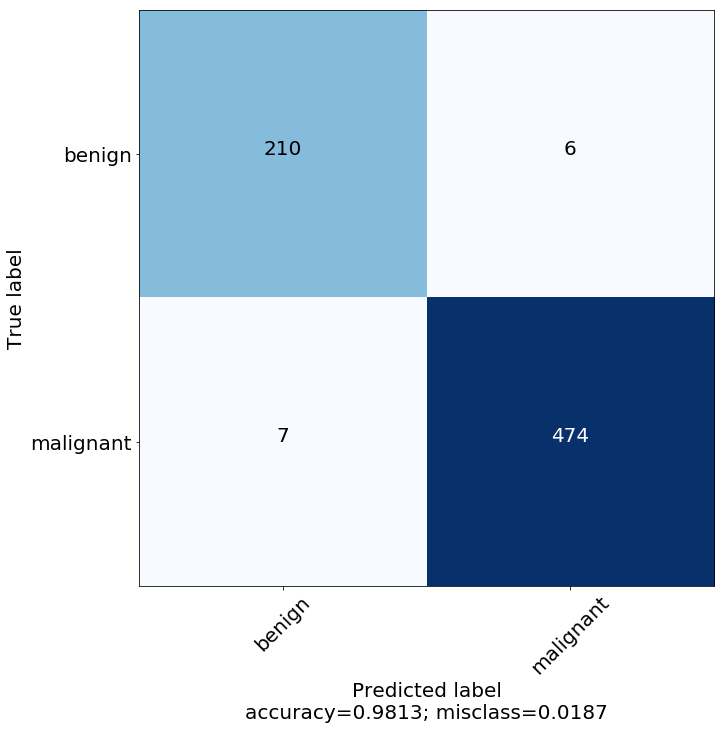

In [14]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [15]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[210   6]
 [  7 474]]
              precision    recall  f1-score   support

      benign       0.97      0.97      0.97       216
   malignant       0.99      0.99      0.99       481

   micro avg       0.98      0.98      0.98       697
   macro avg       0.98      0.98      0.98       697
weighted avg       0.98      0.98      0.98       697



In [16]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  96.7741935483871
Specificity :  98.75


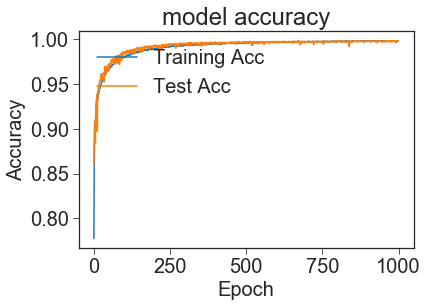

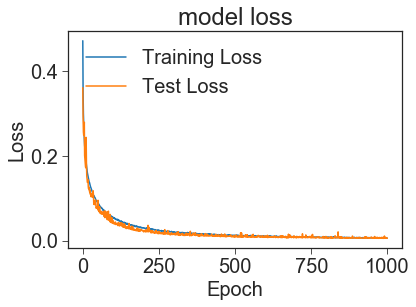

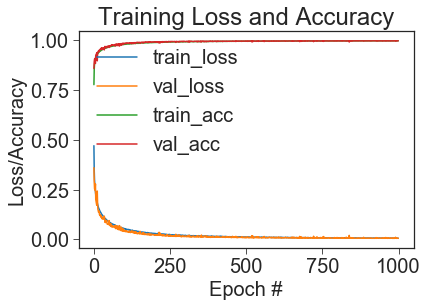

In [17]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

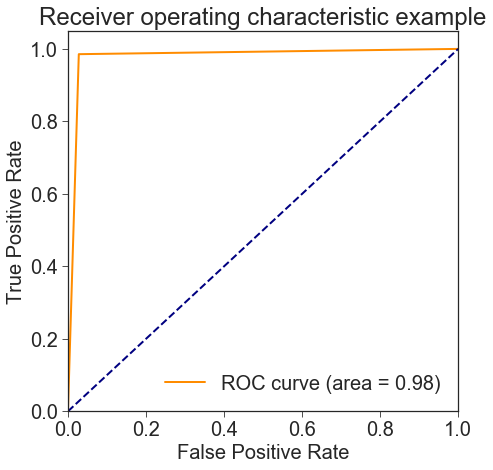

In [19]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [20]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

697/697 [==============================] - 0s 70us/step


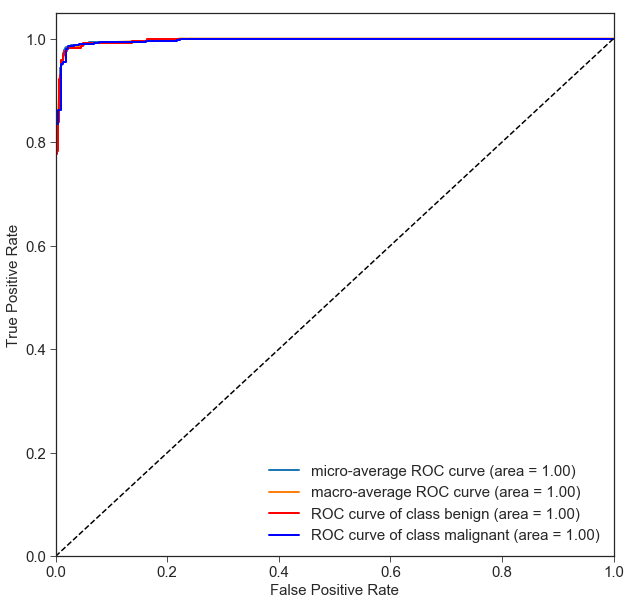

In [21]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [22]:
tn, fp, fn, tp = cm.ravel()

print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.9813486370157819
Precision: 0.9875
Recall: 0.9854469854469855
tp: 474
fp: 6
tn: 210
fn: 7


In [24]:
print('F1 score:', f1_score(y_true, y_pred))

recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.9864724245577523
F1 score: 0.9864724245577525


In [23]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.9776209677419355
